# Multi-class Classification with PyTorch

Multi-class classification problems are the ones that involve more than two labels in the dataset.


## Setup


### Importing libraries


In [1]:
from pathlib import Path
from typing import Tuple, Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim import Adam

from helper_functions.helper_functions import accuracy_fn
from helper_functions.helper_functions import plot_predictions, plot_decision_boundary

### Setting device


In [2]:
# Using gpu if available
device = 'mps' if torch.mps.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: mps


### Defining functions


In [3]:
# Function to automatically run training loop
def training_loop(
    estimator: nn.Module,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    epochs: int,
    train_data: Tuple[torch.Tensor, torch.Tensor],
    validation_data: Tuple[torch.Tensor, torch.Tensor] | None = None,
    seed: int | None = None,
    print_every: int = 10,
) -> Dict[str, List[float]]:

    if seed != None:
        torch.manual_seed(seed)

    X_train, y_train = train_data
    X_val, y_val = validation_data

    data_tracking = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    validation_print = ''

    for epoch in range(epochs):
        estimator.train()

        train_logits = estimator(X_train)
        train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)

        training_loss = loss_fn(train_logits, y_train)
        data_tracking['train_loss'].append(training_loss)

        training_acc = accuracy_fn(y_train, train_preds)
        data_tracking['train_acc'].append(training_acc)

        optimizer.zero_grad()
        training_loss.backward()

        optimizer.step()

        if validation_data != None:
            with torch.inference_mode():
                estimator.eval()
                val_logits = estimator(X_val).squeeze()
                val_preds = torch.softmax(val_logits, dim=1).argmax(dim=1)

                validation_loss = loss_fn(val_logits, y_val)
                data_tracking['val_loss'].append(validation_loss)

                validation_acc = accuracy_fn(val_preds, y_val)
                data_tracking['val_acc'].append(validation_acc)

                validation_print = f'Validation loss: {validation_loss:.2f} | Validation acc: {validation_acc:.2f} |'

        if (epoch + 1) % print_every == 0:
            print(
                f'| Epoch: {epoch + 1} |',
                f'\n| Training loss: {training_loss:.2f} | Training acc: {training_acc:.2f} |',
                validation_print,
            )
            print('-' * 93)

## 1- Creating data


In [4]:
# Setting hyperparameters for data creation
num_samples = 1000
num_classes = 4
num_features = 2
random_seed = 42

In [5]:
# Creating multi-class data
X, y = make_blobs(
    n_samples=num_samples,
    n_features=num_features,
    centers=num_classes,
    cluster_std=1.5,
    random_state=random_seed,
)

In [6]:
# Turning data into tensors
X_blob = torch.from_numpy(X).type(torch.float32).to(device)
y_blob = torch.from_numpy(y).type(torch.float32).to(device)

In [7]:
# Splitting into training and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=random_seed,
)

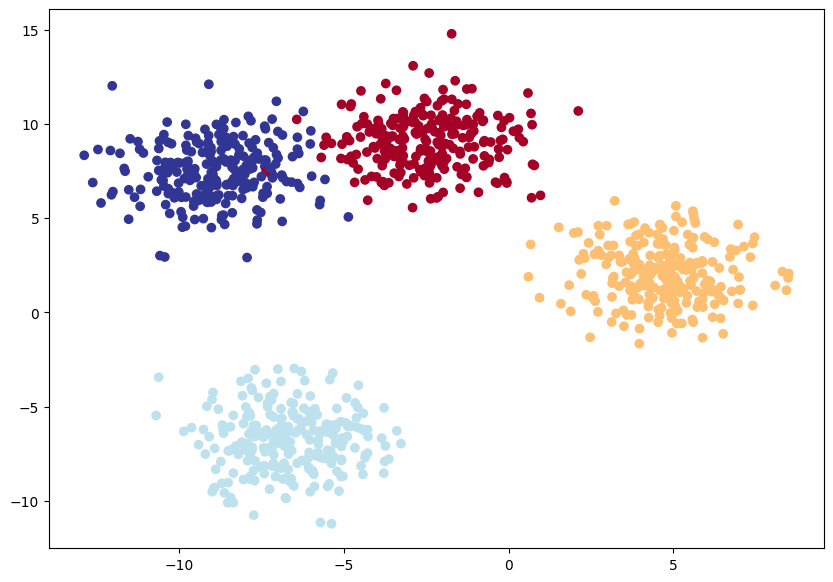

In [8]:
# Plotting the data
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

## 2- Building model


In [9]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8) -> None:
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

In [10]:
# Creating instance of model in target device
model = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)

## 3- Picking loss and optimizer


In [11]:
# Picking loss function
loss_fn = nn.CrossEntropyLoss()

# Picking optimizer
optimizer = Adam(
    params=model.parameters(),
    lr=0.1,
)

## 4- Training model


In [12]:
# Setting number of epochs
epochs = 10

# Training model
data_tracking = training_loop(
    estimator=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    train_data=(X_blob_train, y_blob_train),
    validation_data=(X_blob_test, y_blob_test),
    seed=42,
    print_every=2,
)

| Epoch: 2 | 
| Training loss: 0.78 | Training acc: 90.38 | Validation loss: 0.50 | Validation acc: 97.50 |
---------------------------------------------------------------------------------------------
| Epoch: 4 | 
| Training loss: 0.25 | Training acc: 98.50 | Validation loss: 0.09 | Validation acc: 99.00 |
---------------------------------------------------------------------------------------------
| Epoch: 6 | 
| Training loss: 0.04 | Training acc: 99.12 | Validation loss: 0.02 | Validation acc: 99.50 |
---------------------------------------------------------------------------------------------
| Epoch: 8 | 
| Training loss: 0.03 | Training acc: 98.88 | Validation loss: 0.01 | Validation acc: 99.50 |
---------------------------------------------------------------------------------------------
| Epoch: 10 | 
| Training loss: 0.03 | Training acc: 99.12 | Validation loss: 0.02 | Validation acc: 99.50 |
-----------------------------------------------------------------------------------

## 5- Making predictions and evaluate model


In [13]:
# Making predictions
with torch.inference_mode():
    y_preds = model(X_blob_test)

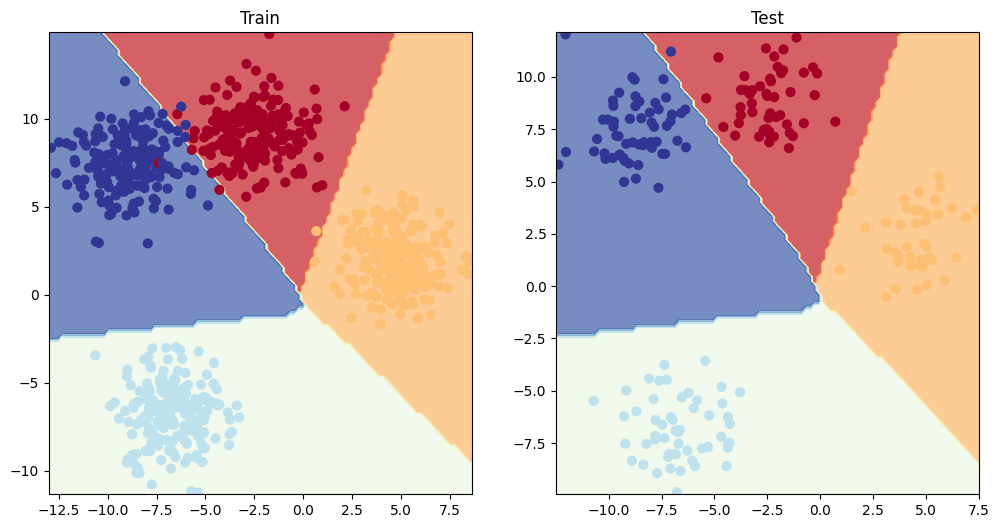

In [14]:
# Plot decision boundary of the model

# Train plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model, X_blob_train, y_blob_train)

# Test plot
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model, X_blob_test, y_blob_test)

## 6- Saving model


In [15]:
# Creating models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Creating model save path
MODEL_NAME = 'multi_class_classification.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/multi_class_classification.pth')

In [16]:
# Saving model state_dict
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

In [17]:
# Loading model
model = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [18]:
# Predicting and checking validity
model.eval()
with torch.inference_mode():
    loaded_lr_preds = model(X_blob_test)

torch.equal(loaded_lr_preds, y_preds)

True